In [55]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/5lxj2ogcizom3m5unfcnlik52m7qie')
df.head(5)

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


In [56]:
df.shape

(6394, 217)

In [57]:
df['SWB_1'].value_counts(normalize=True)
# put 6 and 7 together to get a column for ['satified_w_life']

 6    0.301220
 7    0.240069
 5    0.228026
 4    0.125586
 3    0.052393
 1    0.024085
 2    0.023772
-1    0.004692
-4    0.000156
Name: SWB_1, dtype: float64

Possible things to choose as target: SWB_1 = I am satisfied with my life, FWBscore = Financial well-being scale score. So I could either have the my ML problem be trying to predict one's satisfistion with life based on their responses to the CFPB financial well-being survey or one's financial well-being.

Choose your target. Which column in your tabular dataset will you predict?
 - My target will be trying to predict SWB_1 or I am satisfied with my life (also if curious on how I'm getting the names for these columns here's the link for the codebook https://data.world/cfpb/financial-well-being-survey-data/workspace/file?filename=cfpb_nfwbs-puf-codebook.pdf)
 Is your problem regression or classification?
 - Regression
  How is your target distributed?
  - There are technically 9 classes, but I'm going to use 6 and 7 as true and the rest could be treated as false. 
 Choose your evaluation metric(s).
 - MAE
  Choose which observations you will use to train, validate, and test your model.
- random split

Second Assignment
    -Continue to clean and explore your data.
    
 For the evaluation metric you chose, what score would you get just by guessing?
 
     -Can you make a fast, first model that beats guessing?

In [58]:
df['satisfied_w_life'] = (df['SWB_1'] >= 6)

In [59]:
# getting baselines
from sklearn.metrics import r2_score, mean_absolute_error
target = 'satisfied_w_life'
guess = df[target].mean()
base = df[target]

y_pred = [guess] * len(base)
# r2 = r2_score(base,y_pred)
# print(f'R^2: {r2:}') r2 just shows 0
mae = mean_absolute_error(base,y_pred)
print(f'MAE: {mae:.6f}')

MAE: 0.496590


In [60]:
df['satisfied_w_life'].nunique()

2

In [61]:
df['satisfied_w_life'].value_counts(normalize=True)
# I have to beat 54% for my model to be any value

True     0.541289
False    0.458711
Name: satisfied_w_life, dtype: float64

In [62]:
#creating wrangling function
from sklearn.model_selection import train_test_split

def wrangle(X):
    X = X.copy()
    
    unusable_variance = ['PUF_ID','sample','SWB_1'] # can't have SWB_1 in since i got my target column from there
    X = X.drop(columns = unusable_variance)
    
    return X

target = 'satisfied_w_life'
train, test = train_test_split(df,test_size=0.05,random_state=42)

train, val = train_test_split(train,test_size=0.10,random_state=42)

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
print(train.shape,val.shape,test.shape)

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

(5466, 215) (608, 215) (320, 215)


In [63]:
#first pipeline model
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

pipeline = make_pipeline(
ce.OrdinalEncoder(),    
SimpleImputer(strategy='mean')
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.fit_transform(X_val)

model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
model.fit(X_train_transformed,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
model,
scoring = 'accuracy',
n_iter=5,
random_state=42)
permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [65]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_,feature_names).sort_values(ascending=False)

SWB_2         0.067105
SWB_3         0.015132
FWB1_4        0.003289
FWB2_3        0.002632
DISTRESS      0.001645
                ...   
PRODHAVE_5   -0.006250
PAREDUC      -0.006579
PROPPLAN_2   -0.006579
FWBscore     -0.007566
EMPLOY1_8    -0.008224
Length: 214, dtype: float64

In [66]:
eli5.show_weights(
permuter,
top=None,
feature_names=feature_names)

Weight,Feature
0.0671 ± 0.0253,SWB_2
0.0151 ± 0.0158,SWB_3
0.0033 ± 0.0062,FWB1_4
0.0026 ± 0.0026,FWB2_3
0.0016 ± 0.0055,DISTRESS
0.0016 ± 0.0021,PRODUSE_3
0.0016 ± 0.0021,FS1_3
0.0016 ± 0.0021,FINSOC2_4
0.0016 ± 0.0000,SHOCKS_7
0.0016 ± 0.0000,EMPLOY1_4


In [67]:
minimum_importance = 0

mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [69]:
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val,y_pred))

Validation Accuracy 0.7976973684210527


In [70]:
y_pred = pipeline.predict(X_test)
y_test = y_test[features]
print('Test Accuracy', accuracy_score(y_test,y_pred))
# check later with a graphic to see which feature is taking into account more than others

ValueError: Unexpected input dimension 214, expected 32

 - If you haven't completed assignment #1, please do so first.
 - Continue to clean and explore your data. Make exploratory visualizations.
 - Fit a model. Does it beat your baseline?
 - Try xgboost.
 - Get your model's permutation importances.

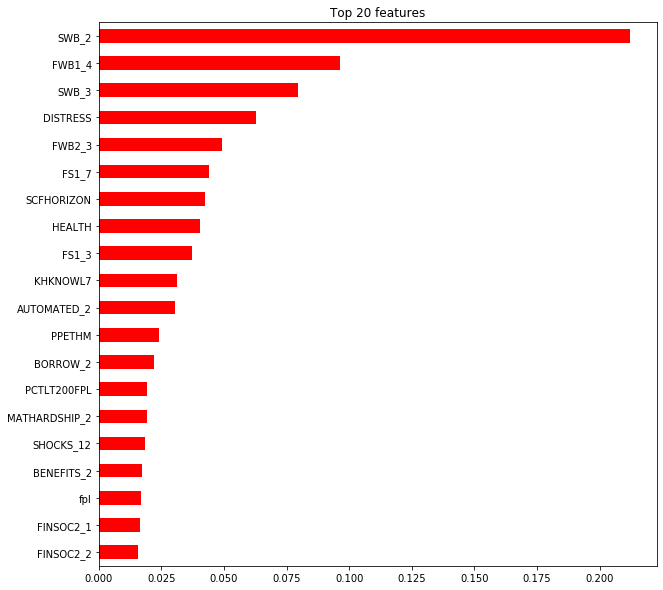

In [71]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_,X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='red');

- SWB_2 = I am optimistic about my future
- FWB1_4 = I can enjoy life because of the way I’m managing my money
- SWB_3 = If I work hard today, I will be more successful in the future
- DISTRESS = Lot of stress in respondent's life
- FWB2_3 = I am behind with my finances